![logo](./img/LogoLine_horizon_C3S.png)

## Tutorial on plotting CARRA and ERA5 data on a map

Here, we do a comparison of CARRA with ERA5. The data was downloaded in script I.

To perform the comparison, we interpolate the ERA5 data onto the CARRA grid with help of the CDOs.



<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/carlos9917/carra-training-c3s/main?labpath=CARRA_plot_CARRA_ERA5_maps.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/carlos9917/carra-training-c3s/blob/main/CARRA_plot_CARRA_ERA5_maps.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/carlos9917/carra-training-c3s/blob/main/CARRA_plot_CARRA_ERA5_maps.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

### Define the files needed for the interpolation.
The CDO command uses the grid description from the CARRA file to interpolate the ERA5 data. The corresponding files are defined here.
We will used the data downloaded in the [previous notebook](CARRA_get_T2m.ipynb)

In [11]:
import os
import warnings
warnings.filterwarnings('ignore') #turn off some warnings

DATADIR="CARRA" #path where the data is saved
#Define the file paths below
period="202403" # the period to plot
fCARRA = os.path.join(DATADIR,"Raw_data","T2m_an_"+period+".grb")
fERA5 = os.path.join(DATADIR,"ERA5","era5_t2m_"+period+".grb")
fERA5_CARRA_grid = os.path.join(DATADIR,"ERA5","era5_t2m_"+period+"_CARRA_grid.nc")

### Interpolation to CARRA grid with CDO
We use the [CDO library](https://code.mpimet.mpg.de/projects/cdo/wiki) to interpolate the data into a common grid
for a fair comparison. 
After importing the CDOs into python it is one line to interpolate between the grids.
Note that CDO can handle both GRIB format and NetCDF data. For instance, CARRA is downloaded in GRIB whereas we downloaded ERA5 as NetCDF.

More information regarding the CDOs (Climate data operators) can be found at https://code.mpimet.mpg.de/projects/cdo

In [12]:
from cdo import *
cdo   = Cdo()

cdo.remapbil(fCARRA, input=fERA5, output=fERA5_CARRA_grid)

'CARRA/ERA5/era5_t2m_202403_CARRA_grid.nc'

### Open the datasets (similar to script II)

In [13]:
import xarray as xr

# Open Datasets
CARRA = xr.open_dataset(fCARRA)
ERA5  = xr.open_dataset(fERA5_CARRA_grid)

# Compute monthly mean
print("Compute the mean")
CARRA_mean = CARRA.mean(dim="time", keep_attrs=True)
ERA5_mean = ERA5.mean(dim="time", keep_attrs=True)
print("Done.")

# Change longitudes from 0-360 to -180 to 180, needed for the plotting
CARRA_mean = CARRA_mean.assign_coords(longitude=(((CARRA_mean.longitude + 180) % 360) - 180))
ERA5_mean = ERA5_mean.assign_coords(longitude=CARRA_mean.longitude)

# Change unit from K to C and add the unit to the attributes
CARRA_mean_C = CARRA_mean - 273.15
CARRA_mean_C = CARRA_mean_C.assign_attrs(CARRA_mean.attrs)
CARRA_mean_C.attrs['units'] = 'deg C'
ERA5_mean_C = ERA5_mean - 273.15
ERA5_mean_C = ERA5_mean_C.assign_attrs(ERA5_mean.attrs)
ERA5_mean_C.attrs['units'] = 'deg C'

Ignoring index file 'CARRA/Raw_data/T2m_an_202403.grb.923a8.idx' older than GRIB file


Compute the mean
Done.


### Plotting of ERA5

Start plotting maps
Print ERA5


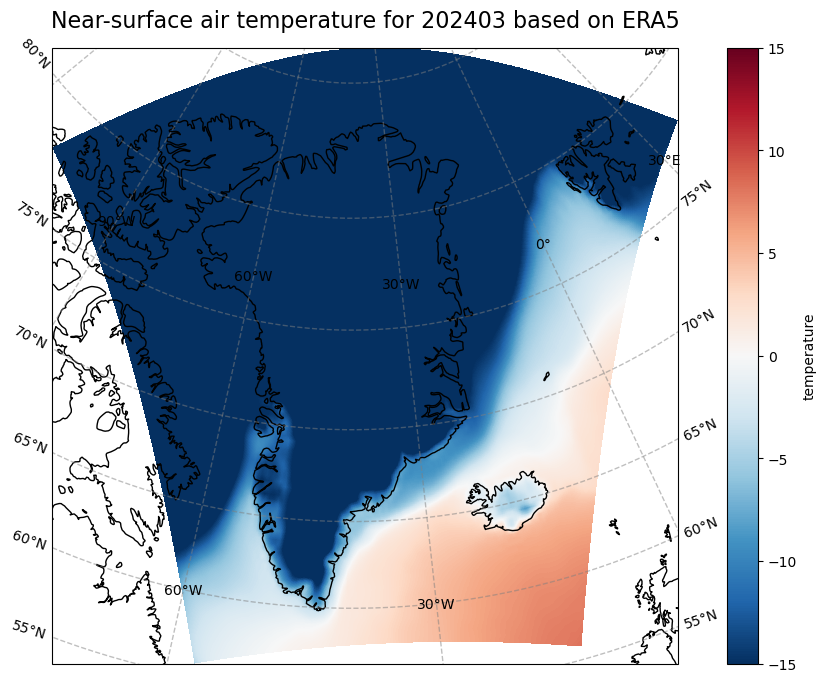

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

print("Start plotting maps")
print("Print ERA5")
# create the figure panel and the map using the Cartopy Lambert conformal projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data
im = plt.pcolormesh(ERA5_mean_C.longitude, ERA5_mean_C.latitude, ERA5_mean_C.t2m, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-15, vmax=15)

# Set the figure title
ax.set_title('Near-surface air temperature for '+period+' based on ERA5', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature')

# Save the figure
if not os.path.isdir(os.path.join(DATADIR,"Figures")):
    os.makedirs(os.path.join(DATADIR,"Figures"))
fig.savefig(f'{DATADIR}/Figures/ERA5_'+period+'_map.png')

### Plot the difference between CARRA and ERA5
Note that the differences are computed in the plotting command itself.

Print CARRA - ERA5


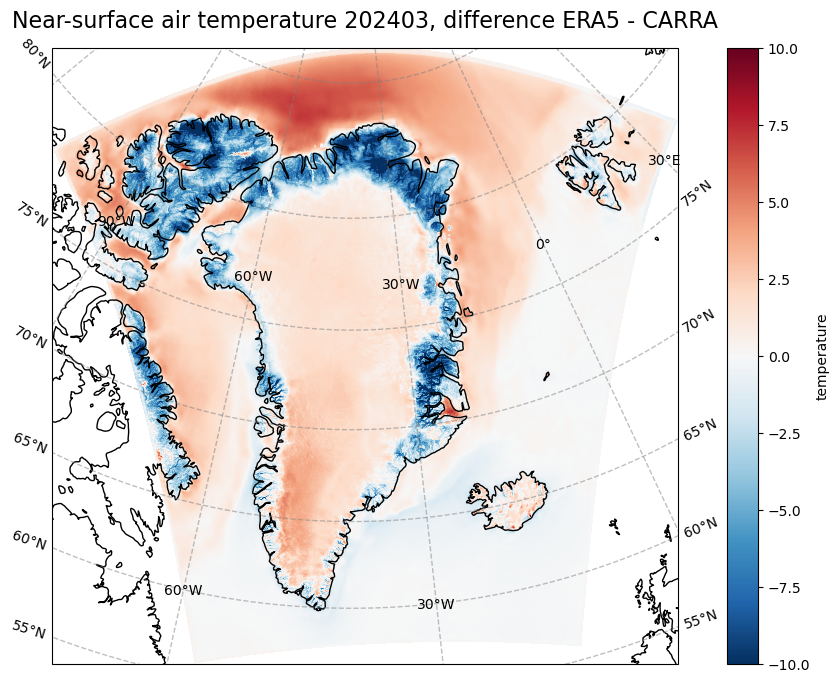

In [15]:
print("Print CARRA - ERA5")
# create the figure panel and the map using the Cartopy Lambert conformal projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data, the differences are computed on the fly.
im = plt.pcolormesh(CARRA_mean_C.longitude, CARRA_mean_C.latitude, ERA5_mean_C.t2m - CARRA_mean_C.t2m,
                    transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-10, vmax=10)

# Set the figure title
ax.set_title('Near-surface air temperature '+period+', difference ERA5 - CARRA', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature')

# Save the figure
fig.savefig(f'{DATADIR}/Figures/ERA5-CARRA_map.png')